# Exercise 4: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [3]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])
df_train.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


**Validation Set**

Use this set to evaluate your model

In [4]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])
df_validation.head()

,text,label
0,VinTee [USERNAME] [USERNAME] and [USERNAME] Ka...,1
1,binay's sidekicks were employees of makati cit...,1
2,This is expected as we use different methodol...,0
3,Ang tanga tanga talaga ni Nancy Binay eh. Tskkk.,1
4,Binay giving away bracelets after every selfie...,0


**Test Set**
  
Use this set to test your model

In [5]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])
df_test.head()

,text,label
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0
2,wait so ur telling me Let Leni Lead mo pero NY...,1
3,[USERNAME]wish this is just a nightmare that ...,0
4,doc willie ong and isko sabunutan po,0


## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [6]:
# put your answer here
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [7]:
# put your answer here
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [8]:
# put your answer here
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [9]:
# put your answer here
df_train.duplicated().sum()

np.int64(0)

5. Check how many rows belong to each class

In [10]:
# put your answer here
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [ ]:
# put your answer here
# No duplicates??

7. Remove rows with NaN values

In [ ]:
# put your answer here
# No NaN??

8. Convert all text to lowercase

In [11]:
# put your answer here
df_train['text'] = df_train['text'].str.lower()
df_validation['text'] = df_validation['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

df_train["text"].head()

,text
0,presidential candidate mar roxas implies that ...
1,parang may mali na sumunod ang patalastas ng n...
2,bet ko. pula ang kulay ng posas
3,[username] kakampink
4,bakit parang tahimik ang mga pink about doc wi...


9. Remove digits, URLS and special characters

In [12]:
# put your answer here
def text_clean(text):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase
    text = re.sub(r"\d+","",text)   #remove digits and currencies
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks
    return text

df_train['text'] = df_train['text'].apply(lambda x: text_clean(x))
df_validation['text'] = df_validation['text'].apply(lambda x: text_clean(x))
df_test['text'] = df_test['text'].apply(lambda x: text_clean(x))

In [13]:
df_train['text'].head()

,text
0,presidential candidate mar roxas implies that ...
1,parang may mali na sumunod ang patalastas ng n...
2,bet ko pula ang kulay ng posas
3,username kakampink
4,bakit parang tahimik ang mga pink about doc wi...


10. Remove stop words

In [14]:
# put your answer here
def remove_stopwords(text):
  filtered_tokens = [word for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
  text = " ".join(filtered_tokens)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_stopwords(x))
df_validation['text'] = df_validation['text'].apply(lambda x: remove_stopwords(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_stopwords(x))


<bound method NDFrame.head of 0        presidential candidate mar roxas implies govt ...
1        parang may mali na sumunod ang patalastas ng n...
2                           bet ko pula ang kulay ng posas
3                                       username kakampink
4        bakit parang tahimik ang mga pink doc willie o...
                               ...                        
21768                     marcos talunan marcos magnanakaw
21769                                 grabe kayo kay binay
21770    username cnu ba naman ang hindimabibighani sa ...
21771    rt username tabi tabi yung mga nagsasabing par...
21772    honestly dont get kakampinks like pano nila na...
Name: text, Length: 21773, dtype: object>

In [15]:
df_train['text'].head()

,text
0,presidential candidate mar roxas implies govt ...
1,parang may mali na sumunod ang patalastas ng n...
2,bet ko pula ang kulay ng posas
3,username kakampink
4,bakit parang tahimik ang mga pink doc willie o...


11. Use Stemming or Lemmatization

In [16]:
# put your answer here
def leminize_text(text):
  lemmer = WordNetLemmatizer()
  lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
  return " ".join(lemm_tokens)

df_train['text'] = df_train['text'].apply(lambda x: leminize_text(x))
df_validation['text'] = df_validation['text'].apply(lambda x: leminize_text(x))
df_test['text'] = df_test['text'].apply(lambda x: leminize_text(x))

In [17]:
df_train['text'].head()

,text
0,presidential candidate mar roxas implies govt ...
1,parang may mali na sumunod ang patalastas ng n...
2,bet ko pula ang kulay ng posas
3,username kakampink
4,bakit parang tahimik ang mga pink doc willie o...


In [18]:
df_validation['text'].head()

,text
0,vintee username username username kaya di aase...
1,binays sidekick employee makati city hall able...
2,expected use different methodology pulse asia ...
3,ang tanga tanga talaga ni nancy binay eh tskkk
4,binay giving away bracelet every selfie username


In [20]:
df_test['text'].head()

,text
0,binay patuloy ang kahirapan dahil sa maling pa...
1,sa gobyernong tapat welcome sa baguo ang lahat...
2,wait ur telling let leni lead mo pero nyong uy...
3,usernamewish nightmare could end pa failed let...
4,doc willie ong isko sabunutan po


## C. Training your model

12. Put all text training data in variable **X_train**

In [21]:
# put your answer here
X_train = df_train['text']

13. Put all training data labels in variable **y_train**

In [22]:
# put your answer here
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [23]:
# put your answer here
vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

15. Create an instance of `MultinomalNB()`

In [24]:
# put your answer here
model = MultinomialNB()

16. Train the model using `.fit()`

In [25]:
# put your answer here
model.fit(X_train_transformed, y_train)

MultinomialNB()

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [26]:
# put your answer here
X_validation = df_validation['text']
X_validation_transformed = vectorizer.transform(X_validation)
y_validation_pred = model.predict(X_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [27]:
# put your answer here
y_validation = df_validation['label']

In [29]:
accuracy = accuracy_score(y_validation, y_validation_pred)
balanced_accuracy = balanced_accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)

print("Accuracy:",round(100*accuracy,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
print("Precision:", round(100*precision,2),'%')

Accuracy: 83.46 %
Balanced accuracy: 83.4 %
Precision: 80.4 %


19. Create a confusion matrix using the **validation dataset**

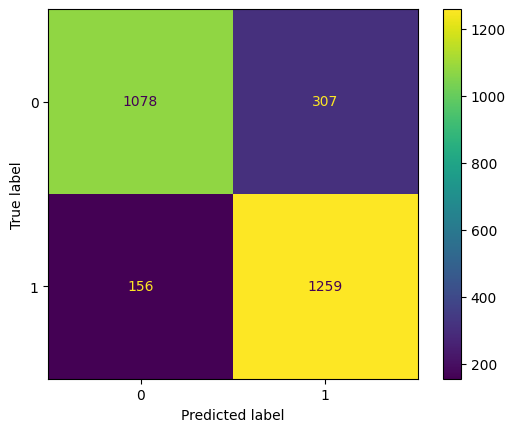

In [31]:
# put your answer here
cm = confusion_matrix(y_validation, y_validation_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [32]:
# put your answer here
X_test = df_test['text']
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [33]:
# put your answer here
y_test = df_test['label']

accuracy = accuracy_score(y_test, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)

print("Accuracy:",round(100*accuracy,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
print("Precision:", round(100*precision,2),'%')

Accuracy: 83.31 %
Balanced accuracy: 83.34 %
Precision: 79.95 %


22. Create a confusion matrix using the **test dataset**

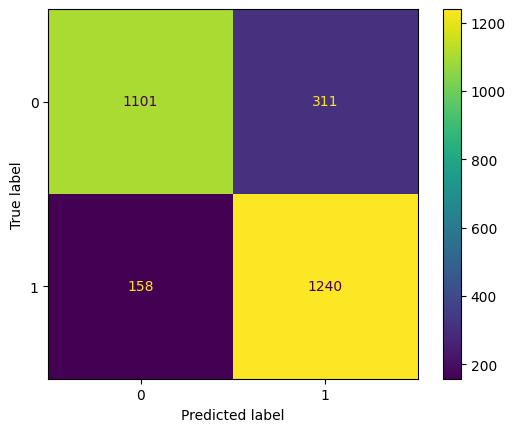

In [34]:
# put your answer here
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [52]:
# put your answer here
new_text = pd.Series('I love you')
new_text_transform = vectorizer.transform(new_text)
print(model.predict(new_text_transform))

[0]


24. Test the model by providing a hate speech input. The model should predict it as 1

In [48]:
# put your answer here
new_text = pd.Series('You are kind of ass')
new_text_transform = vectorizer.transform(new_text)
print(model.predict(new_text_transform))

[1]
